In [1]:
import random
import time
from concurrent.futures import ThreadPoolExecutor
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class Task:
    def __init__(self, name, service_time, arrival_time):
        self.name = name
        self.service_time = random.expovariate(1 / service_time)
        self.priority = self.generate_priority()
        self.arrival_time = time.time()
        self.finish_time = time.time()
        
    def generate_priority(self):
        r = random.random()
        if r <= 0.2:
            return 'high'
        elif r <= 0.5:
            return 'medium'
        else:
            return 'low'

    def __lt__(self, other):
        return self.service_time < other.service_time


In [3]:
T = 30  # 10 seconds of simulation time
k = 3  # 3 servers
lambda_param = 5  # Poisson distribution parameter
max_queue_size = 10  # Maximum queue size for each server
policy = 'weighted_round_robin'  # Choose from 'fifo', 'weighted_round_robin', or 'non_preemptive_priority'

In [4]:
def task_generator(T, lambda_param, start_time):
    current_time = start_time
    task_count = 0
    while current_time < T + start_time:
        task_count += 1
        inter_arrival_time = random.expovariate(lambda_param)
        time.sleep(inter_arrival_time)
        current_time += inter_arrival_time
        yield Task(f"Task {task_count}", inter_arrival_time, time.time())


In [5]:
def process_task(queue, policy):
    if policy == 'fifo':
        task = fifo_policy(queue)
    elif policy == 'weighted_round_robin':
        task = weighted_round_robin_policy(queue)
    elif policy == 'non_preemptive_priority':
        task = non_preemptive_priority_policy(queue)
    else:
        raise ValueError(f"Unknown policy: {policy}")

    if task:
        time_in_queue = time.time() - task.arrival_time
        time.sleep(task.service_time)
        task.finish_time = time.time()
        # print(f"{task.name} with priority {task.priority} is processed")


In [6]:
def fifo_policy(queue):
    return queue.get()

def weighted_round_robin_policy(queue):
    high_priority = [task for task in queue.queue if task.priority == 'high']
    medium_priority = [task for task in queue.queue if task.priority == 'medium']
    low_priority = [task for task in queue.queue if task.priority == 'low']
    if high_priority:
        return high_priority.pop(0)
    elif medium_priority:
        return medium_priority.pop(0)
    elif low_priority:
        return low_priority.pop(0)
    else:
        return None

def non_preemptive_priority_policy(queue):
    sorted_tasks = sorted(queue.queue, key=lambda task: task.priority)
    task = sorted_tasks.pop(0)
    queue.queue.remove(task)
    return task


In [7]:
def run_simulation(T, k, lambda_param, max_queue_size, policy):
    if policy == 'weighted_round_robin':
        task_queues = [{'high': PriorityQueue(maxsize=max_queue_size), 
                        'medium': PriorityQueue(maxsize=max_queue_size), 
                        'low': PriorityQueue(maxsize=max_queue_size)} for _ in range(k)]
    else:
        task_queues = [PriorityQueue(maxsize=max_queue_size) for _ in range(k)]
    dropped_tasks = 0
    total_tasks = 0
    total_queue_sizes = [0] * k
    total_task_times = [0] * k
    server_busy_times = [0] * k
    task_arrival_times = []

    start_time = time.time()
    active_tasks = []
    with ThreadPoolExecutor(max_workers=k) as executor:
        for task in task_generator(T, lambda_param,start_time):
            total_tasks += 1
            task_arrival_times.append((total_tasks, time.time() - start_time))
            if policy == 'weighted_round_robin':
                min_queue = min(task_queues, key=lambda q: q[task.priority].qsize())
                if min_queue[task.priority].full():
                    dropped_tasks += 1
                else:
                    active_tasks.append(task)
                    min_queue_idx = task_queues.index(min_queue)
                    total_queue_sizes[min_queue_idx] += 1
                    total_task_times[min_queue_idx] += task.service_time
                    server_busy_times[min_queue_idx] += task.service_time
                    min_queue[task.priority].put(task)
                    executor.submit(process_task, min_queue[task.priority], policy)
            else:
                min_queue = min(task_queues, key=lambda q: q.qsize())
                if min_queue.full():
                    dropped_tasks += 1
                else:
                    active_tasks.append(task)
                    min_queue_idx = task_queues.index(min_queue)
                    total_queue_sizes[min_queue_idx] += 1
                    total_task_times[min_queue_idx] += task.service_time
                    server_busy_times[min_queue_idx] += task.service_time
                    min_queue.put(task)
                    executor.submit(process_task, min_queue, policy)
    cook = []
    for task in active_tasks :
        if task.priority == 'high' :
            running_time = (task.finish_time - task.arrival_time)*1000
            if running_time != 0:
                cook.append(running_time)
    avg_queue_sizes = [size / total_tasks for size in total_queue_sizes]
    avg_time_spent_queues = [task_time / total_tasks for task_time in total_task_times]
    avg_server_utilization = [busy_time / T for busy_time in server_busy_times]

    return dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization, cook


In [8]:
dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization,high_priority_times = run_simulation(T, k, lambda_param, max_queue_size, policy)
print(f"Total tasks generated: {total_tasks}")
print(f"Dropped tasks: {dropped_tasks}")
print(f"Average queue sizes: {avg_queue_sizes}")
print(f"Average time spent in all queues: {sum(avg_time_spent_queues) / len(avg_time_spent_queues)}")
print(f"Average time spent in each queue: {avg_time_spent_queues}")
print(f"Average server utilization: {avg_server_utilization}")


Total tasks generated: 164
Dropped tasks: 74
Average queue sizes: [0.18292682926829268, 0.18292682926829268, 0.18292682926829268]
Average time spent in all queues: 0.03268756197625237
Average time spent in each queue: [0.037499244465858415, 0.025232426598107042, 0.03533101486479164]
Average server utilization: [0.20499586974669268, 0.13793726540298518, 0.193142881260861]


In [9]:
scheduling_policies = ['fifo', 'weighted_round_robin', 'non_preemptive_priority']
high_priority_times_by_policy = {}
for policy in scheduling_policies:
    np.random.seed(None)
    dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization,high_priority_times = run_simulation(T, k, lambda_param, max_queue_size, policy)
    print(high_priority_times)
    high_priority_times_by_policy[policy] = high_priority_times

[277.7750492095947, 13.086318969726562, 468.0194854736328, 663.7494564056396, 1486.4161014556885, 501.60837173461914, 46.40054702758789, 211.5023136138916, 17.716169357299805, 38.01083564758301, 67.05927848815918, 30.766963958740234, 11.25192642211914, 53.77840995788574, 4.664182662963867, 40.094614028930664, 50.24099349975586, 13.036489486694336, 123.33011627197266, 92.90266036987305, 157.4420928955078, 160.7379913330078, 187.77942657470703, 4.999637603759766, 557.4698448181152, 32.75179862976074, 120.53918838500977, 520.2615261077881, 31.3265323638916]
[24865.998029708862, 32.62829780578613, 3107.7334880828857, 7.719755172729492, 3.9811134338378906, 103.97887229919434, 17531.631469726562, 2923.971176147461, 11161.75889968872]
[58.33077430725098, 90.74783325195312, 20.9963321685791, 383.9290142059326, 51.027536392211914, 714.7417068481445, 1682.7971935272217, 2064.469814300537, 6.989002227783203, 147.99928665161133, 4.000186920166016, 15.990018844604492, 178.98941040039062, 161.026477

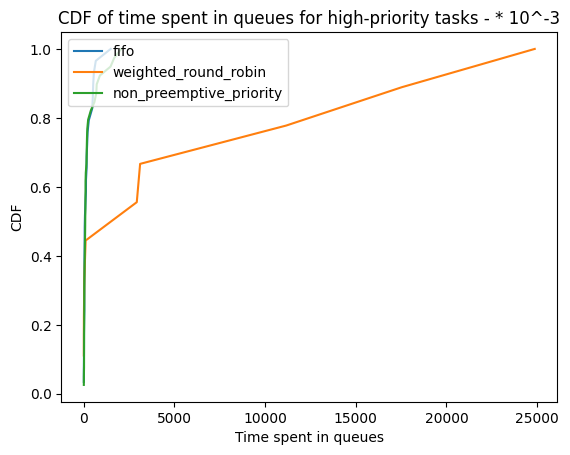

In [10]:
for policy, high_priority_times in high_priority_times_by_policy.items():
    sorted_times = np.sort(high_priority_times)
    yvals = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    plt.plot(sorted_times, yvals, label=policy)

plt.xlabel('Time spent in queues')
plt.ylabel('CDF')
plt.legend(loc='upper left')
plt.title('CDF of time spent in queues for high-priority tasks - * 10^-3')
plt.show()

# Improving utlization
The most basic thing we can do, is to reduce the queue size, however this results in packets being more dropped.

# Queue policy comparison
Based on the CDF plot, round robin scheduling makes packets spend a lot of time in the queue, thus it's not a good choise. FIFO and Non-Preemptive priority work almost the same, but non preemptive is a little bit better.
